In [2]:
import os
import ast
import sys
import cv2
import json
import ndjson
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
sys.path.append('../')
from utils import normalize_image, plot_image, plot_images, get_sequences

## Collect results from txt files

In [52]:
def parse_results_txt(results_txt):
    results = {}
    with open(results_txt, "r") as f:
        data = f.readlines()
        for line in data:
            if ": " in line:
                k, v = line.split(": ")
                if len(v) > 0 and v != 'nan':
                    results[k] = float(v)
    return results

def collect_results(pred_root_dir, models, safety_sets, prod_sets, size_list):
    safety_cols = sorted([v+"_"+size for v in list(safety_sets.values()) for size in size_list])
    prod_cols = sorted([v+"_"+size for v in list(prod_sets.values()) for size in size_list])
    columns = \
        ["model"] + \
        ["safety_avg", "prod_avg"] + \
        safety_cols + \
        prod_cols
    df = pd.DataFrame(columns=columns)

    df_records = []
    for model in models:
        row = {"model": model}
        for safety_set, safety_set_shortname in safety_sets.items():
            for size in size_list:
                results_txt = os.path.join(pred_root_dir, model, safety_set+"_"+size, "results.txt")
                results = parse_results_txt(results_txt)
                row[safety_set_shortname+"_"+size] = results["recall_image"]
        for prod_set, prod_set_shortname in prod_sets.items():
            for size in size_list:
                results_txt = os.path.join(pred_root_dir, model, prod_set+"_"+size, "results.txt")
                results = parse_results_txt(results_txt)
                row[prod_set_shortname+"_"+size] = results["productivity_image"]
        row["safety_avg"] = np.mean([row[safety_col] for safety_col in safety_cols])
        row["prod_avg"] = np.mean([row[prod_col] for prod_col in prod_cols])
        df_records.append(row)
    df = pd.DataFrame.from_dict(df_records)
    return df[columns]

In [55]:
pred_root_dir = "/data/jupiter/li.yu/exps/driveable_terrain_model/"
models = [
    "rgb_baseline_sample_a_v3_2", 
    "sa3_rgb_8cls_1002", 
    "sa3_rgbnir0822_rgb_8cls_1002", 
    "sa3_rgbnir0822rd_rgb_8cls_1002", 
    "sa3_rgbnir0822rdcc_rgb_8cls_1003",
]
safety_sets = {
    "humans_on_path_v5_2023_halo_test_set_anno_with_ocal": "human_v5",
}
prod_sets = {
    "20230912_halo_rgb_productivity_day_candidate_1_cleaned_v3_no_ocal": "day_1", 
    "20230929_halo_rgb_productivity_day_candidate_4_cleaned_v2_no_ocal": "day_4", 
    "20230929_halo_rgb_productivity_day_candidate_8_cleaned_v1_with_ocal_no_drop": "day_8", 
    "20230929_halo_rgb_productivity_day_candidate_10_cleaned_v1_no_ocal": "day_10", 
    "20230929_halo_rgb_productivity_day_candidate_12_dirty_cleaned_v0_no_ocal": "day_12", 
    "20230929_halo_rgb_productivity_day_candidate_13_dirty_no_ocal": "day_13", 
    "20230912_halo_rgb_productivity_night_candidate_0_no_ocal_rgb_branch": "night_0", 
    "20230929_halo_rgb_productivity_night_candidate_4_cleaned_v1_no_ocal": "night_4"
}
size_list = ["640", "768"]

In [60]:
df = collect_results(pred_root_dir, models, safety_sets, prod_sets, size_list)
df.round(5)

,model,safety_avg,prod_avg,human_v5_640,human_v5_768,day_10_640,day_10_768,day_12_640,day_12_768,day_13_640,...,day_1_640,day_1_768,day_4_640,day_4_768,day_8_640,day_8_768,night_0_640,night_0_768,night_4_640,night_4_768
0,rgb_baseline_sample_a_v3_2,0.99755,0.98998,0.99840,0.99670,0.99727,0.99317,0.99839,0.99841,0.99758,...,1.00000,0.99787,0.99443,0.99110,0.94434,0.93008,1.0,1.0,0.99928,0.99920
1,sa3_rgb_8cls_1002,0.99510,0.99037,0.99681,0.99340,0.99864,0.99488,0.99901,0.99874,0.99758,...,1.00000,0.99681,0.99461,0.99165,0.94710,0.92919,1.0,1.0,0.99986,0.99967
2,sa3_rgbnir0822_rgb_8cls_1002,0.99673,0.98840,0.99840,0.99505,0.98636,0.98179,0.99858,0.99836,0.99677,...,1.00000,0.99362,0.99210,0.99090,0.94848,0.93804,1.0,1.0,0.99270,0.99814
3,sa3_rgbnir0822rd_rgb_8cls_1002,0.99755,0.98904,0.99840,0.99670,0.99045,0.98862,0.99907,0.99834,0.99597,...,0.99718,0.99362,0.99461,0.99199,0.95078,0.93698,1.0,1.0,0.99147,0.99648
4,sa3_rgbnir0822rdcc_rgb_8cls_1003,0.99796,0.98932,0.99840,0.99752,0.99591,0.98919,0.99716,0.99736,0.99677,...,0.99435,0.99469,0.99497,0.99220,0.95032,0.93733,1.0,1.0,0.99263,0.99745


## Evaluate performance on distance

In [11]:
# root_dir = '/data/jupiter/li.yu/data'
# root_dir = '/data/jupiter/datasets'
root_dir = '/data2/jupiter/datasets'
# dataset = 'Jupiter_train_v6_2'
# dataset = 'Jupiter_halo_implement_labeled_data_test_06162023_stereo'
# dataset = 'halo_rgb_stereo_train_v6_1'
# dataset = 'halo_rgb_stereo_test_v6_1'
# dataset = 'halo_rgb_stereo_train_v6_2_full_res'
# dataset = 'vehicles_annotations_interim_halo_v6_2_mainline'
dataset = 'halo_humans_on_path_test_v6_2_2_test_dataset'
csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
# converters = {}
df = pd.read_csv(csv, converters=converters).drop_duplicates(subset='unique_id')
df.shape

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (23,80,91,92,93,94,95,97,98,100,101,102,103,104,105,106,107,108,118,178,179,185,187,197,198,202,203,204,205,225,230,231,232,235,237,241,252,253,286,287) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(15948, 326)

In [20]:
# get distance df
dist_csv = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/test_v6_2.csv'
dist_df = pd.read_csv(dist_csv).drop_duplicates(subset='unique_id')
dist_df.shape

# merge with dataset df
df2 = dist_df.merge(df[['unique_id', 'stereo_pipeline_npz_save_path', 'rectified_label_save_path']], on='unique_id').drop_duplicates(subset='unique_id')
# df2 = df_output.merge(df, on='unique_id').drop_duplicates(subset='unique_id')
print(df2.shape)

# get human and vehicle aspect ratio (width / height)
df2['human_aspect_ratio'] = None
df2.loc[df2['is_human_present'] == 'Yes', 'human_aspect_ratio'] = (df2['human_max_col'] - df2['human_min_col'] + 1) / (df2['human_max_row'] - df2['human_min_row'] + 1)
df2['vehicle_aspect_ratio'] = None
df2.loc[df2['is_vehicle_present'] == 'Yes', 'vehicle_aspect_ratio'] = (df2['vehicle_max_col'] - df2['vehicle_min_col'] + 1) / (df2['vehicle_max_row'] - df2['vehicle_min_row'] + 1)

# get distance based counts
distance_cols = []
for d in range(0, 100, 10):
    df2[f'human_{d}_{d+10}m'] = (df2['is_human_present'] == 'Yes') & (df2['human_90_percentile_depth'] >= d/100) & (df2['human_90_percentile_depth'] < d/100+0.1)
    df2.loc[df2[f'human_{d}_{d+10}m'] == True, f'human_{d}_{d+10}m'] = 'Yes'
    df2.loc[df2[f'human_{d}_{d+10}m'] == False, f'human_{d}_{d+10}m'] = None
    df2[f'vehicle_{d}_{d+10}m'] = (df2['is_vehicle_present'] == 'Yes') & (df2['vehicle_90_percentile_depth'] >= d/100) & (df2['vehicle_90_percentile_depth'] < d/100+0.1)
    df2.loc[df2[f'vehicle_{d}_{d+10}m'] == True, f'vehicle_{d}_{d+10}m'] = 'Yes'
    df2.loc[df2[f'vehicle_{d}_{d+10}m'] == False, f'vehicle_{d}_{d+10}m'] = None
    distance_cols.append(f'human_{d}_{d+10}m')
    distance_cols.append(f'vehicle_{d}_{d+10}m')
print(df2.shape)

(15932, 22)
(15932, 44)


In [46]:
pred_root_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model'
models = [
    'v62_50k_lite12_pt_0323',
    'v62_50k_lite12_pt_cnp_0323',
    'v62_50k_lite12_pt_cnp_ds02505_0324',
    # 'v62_50k_lite12_pt_cnp_ds07505_0324',
    ]
pred_suffix = ['_RGBD_0,0_640', '_RGBD_0,0_768']

def get_pred_df(pred_root_dir, model, dataset, pred_suffix):
    dfs = [pd.read_csv(os.path.join(pred_root_dir, model, dataset+ps, 'output.csv')) for ps in pred_suffix]
    return pd.concat(dfs, ignore_index=True)

def get_safety(df):
    tp_cnt = len(df[df.state == 'true_positive'])
    fn_cnt = len(df[df.state == 'false_negative'])
    safety = tp_cnt / (tp_cnt + fn_cnt + 1e-6)
    return safety

def get_distance_based_safety(pred_df):
    safety_results = []
    X = [f'{d}_{d+10}' for d in range(0, 100, 10)]
    for d in range(0, 100, 10):
        sub_df = pred_df[(pred_df[f'human_{d}_{d+10}m'] == 'Yes')]
        safety_results.append(get_safety(sub_df))
    return X, safety_results

def get_pixel_based_safety(pred_df, pixel_bins):
    X, safety_results = [], []
    for i in range(len(pixel_bins)-1):
        X.append(f'{pixel_bins[i]}_{pixel_bins[i+1]}')
        sub_df = pred_df[(pred_df.human_pixels > pixel_bins[i]) & (pred_df.human_pixels <= pixel_bins[i+1])]
        safety_results.append(get_safety(sub_df))
    return X, safety_results

# def get_results_from_csv(pred_root_dir, model, dataset, pred_suffix, data_dist_df):
#     pred_df = get_pred_df(pred_root_dir, model, dataset, pred_suffix)

#     pred_df2 = data_dist_df.merge(pred_df, on='unique_id').drop_duplicates(subset='unique_id')
#     print(pred_df.shape, pred_df2.shape)

#     X, Y = get_distance_based_safety(pred_df2)
#     return X, Y

def plot_bar_chart(X, Ys, models, metric_key='Distance (m)'):
    plt.figure(1, figsize=(10, 5))
    X_axis = np.arange(len(X))
    for i, (model,Y) in enumerate(zip(models, Ys)):
        plt.bar(X_axis + (i - len(Ys) // 2)*0.2, Y, 0.2, label=model)
    plt.xticks(X_axis, X) 
    plt.xlabel(f"Human {metric_key}") 
    plt.ylabel("Human Recall") 
    plt.title(f"Human Recall on {metric_key}") 
    plt.legend(loc='lower right') 
    plt.show() 

In [21]:
mi = 0
pred_df = get_pred_df(pred_root_dir, models[mi], dataset, pred_suffix)
print(pred_df.shape)

pred_df2 = df2.merge(pred_df, on='unique_id').drop_duplicates(subset='unique_id')
print(pred_df2.shape)

(15948, 11)
(15932, 54)


In [22]:
df2.head(2)

,unique_id,image_size,is_human_present,human_pixels,human_min_row,human_max_row,human_min_col,human_max_col,human_median_depth,human_90_percentile_depth,...,human_50_60m,vehicle_50_60m,human_60_70m,vehicle_60_70m,human_70_80m,vehicle_70_80m,human_80_90m,vehicle_80_90m,human_90_100m,vehicle_90_100m
0,64de6c1e3412ff7683591a9f_T01_T03,"(512, 768)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
1,64de71bd4faf245bf3dd3342_T01_T03,"(512, 768)",Yes,2047.0,385.0,455.0,701.0,767.0,0.05184,0.054494,...,None,None,None,None,None,None,None,None,None,None


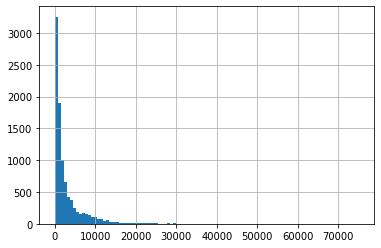

In [36]:
pred_df2.human_pixels.hist(bins=100)
plt.show()

process v62_50k_lite12_pt_0323
(15948, 11) (15932, 54)
process v62_50k_lite12_pt_cnp_0323
(15948, 11) (15932, 54)
process v62_50k_lite12_pt_cnp_ds02505_0324
(15948, 11) (15932, 54)


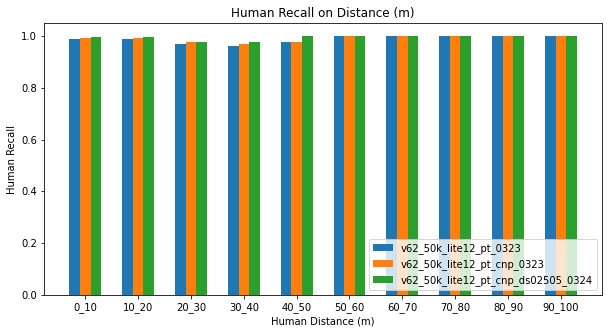

In [47]:
# human distance based results
# X = [f'{d}_{d+10}' for d in range(0, 100, 10)]
Ys = []
for model in models:
    print('process', model)
    pred_df = get_pred_df(pred_root_dir, model, dataset, pred_suffix)
    pred_df2 = df2.merge(pred_df, on='unique_id').drop_duplicates(subset='unique_id')
    print(pred_df.shape, pred_df2.shape)
    X, Y = get_distance_based_safety(pred_df2)
    Ys.append(Y)

plot_bar_chart(X, Ys, models, metric_key='Distance (m)')

process v62_50k_lite12_pt_0323
(15948, 11) (15932, 54)
process v62_50k_lite12_pt_cnp_0323
(15948, 11) (15932, 54)
process v62_50k_lite12_pt_cnp_ds02505_0324
(15948, 11) (15932, 54)


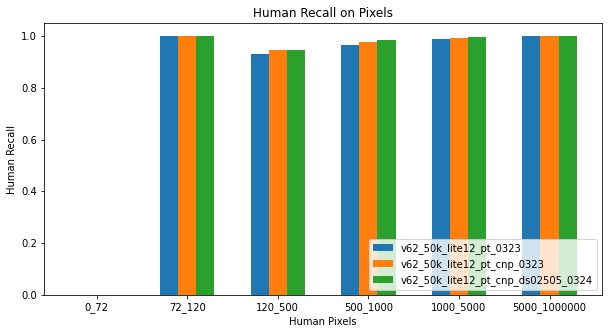

In [48]:
# human pixel based results
pixel_bins = [0, 72, 120, 500, 1000, 5000, 1000000]
Ys = []
for model in models:
    print('process', model)
    pred_df = get_pred_df(pred_root_dir, model, dataset, pred_suffix)
    pred_df2 = df2.merge(pred_df, on='unique_id').drop_duplicates(subset='unique_id')
    print(pred_df.shape, pred_df2.shape)
    X, Y = get_pixel_based_safety(pred_df2, pixel_bins)
    Ys.append(Y)

plot_bar_chart(X, Ys, models, metric_key='Pixels')